In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/heart-failure-prediction/heart.csv


# Setting Up


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from matplotlib import rcParams

from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings(action='ignore')

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Defining a function to plot histograms with ease through the project


In [3]:
# Function to plot histogram for exploratory data analysis
def plot_histgram(feature):    
    sns.set(font_scale = 1)
    sns.set_style("white")
    g = sns.FacetGrid(df,hue="HeartDisease",palette='viridis',height=6,aspect=2)
    g = g.map(plt.hist,feature,bins=20,alpha=0.5)
    plt.legend(labels=['Normal','Heart Disease'])

In [4]:
# Function to plot countplot for exploratory data analysis
def plot_countplot(feature):    
    total_cnt = df['HeartDisease'].count()
    plt.figure(figsize=(12,8))
    sns.set(font_scale = 1)
    sns.set_style("white")
    ax = sns.countplot(data=df,x=feature,hue='HeartDisease',palette='viridis')
    labels = ['Normal','Heart Disease']
    for p in ax.patches:
        x, height, width = p.get_x(), p.get_height(), p.get_width()
        ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=16)
    plt.legend(labels=labels)
    plt.tight_layout()
    sns.despine()

# Reading the data

In [5]:
# Reading the dataset
df = pd.read_csv("../input/heart-failure-prediction/heart.csv")

-----------------------------------------------------------------
## Features
* **Age**: age of the patient [years]
* **Sex**: sex of the patient [M: Male, F: Female]
* **ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* **RestingBP**: resting blood pressure [mm Hg]
* **Cholesterol**: serum cholesterol [mm/dl]
* **FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* **RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]
* **ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]
* **Oldpeak**: oldpeak = ST [Numeric value measured in depression]
* **ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* **HeartDisease**: output class [1: heart disease, 0: Normal]

# Exploring Data

In [6]:
df.head(5).transpose()

,0,1,2,3,4
Age,40,49,37,48,54
Sex,M,F,M,F,M
ChestPainType,ATA,NAP,ATA,ASY,NAP
RestingBP,140,160,130,138,150
Cholesterol,289,180,283,214,195
FastingBS,0,0,0,0,0
RestingECG,Normal,Normal,ST,Normal,Normal
MaxHR,172,156,98,108,122
ExerciseAngina,N,N,N,Y,N
Oldpeak,0.0,1.0,0.0,1.5,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [9]:
df.corr()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.254399,-0.095282,0.198039,-0.382045,0.258612,0.282039
RestingBP,0.254399,1.000000,0.100893,0.070193,-0.112135,0.164803,0.107589
Cholesterol,-0.095282,0.100893,1.000000,-0.260974,0.235792,0.050148,-0.232741
FastingBS,0.198039,0.070193,-0.260974,1.000000,-0.131438,0.052698,0.267291
MaxHR,-0.382045,-0.112135,0.235792,-0.131438,1.000000,-0.160691,-0.400421
Oldpeak,0.258612,0.164803,0.050148,0.052698,-0.160691,1.000000,0.403951
HeartDisease,0.282039,0.107589,-0.232741,0.267291,-0.400421,0.403951,1.000000


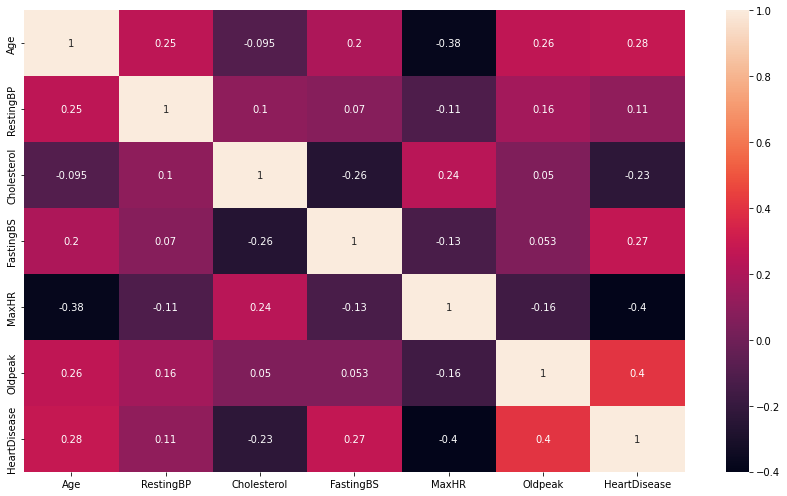

In [10]:
plt.figure(figsize=(12,7))
df.corr()
sns.heatmap(df.corr(),annot=True)
plt.tight_layout()

------------------------------------
# Checking Missing Values

As shown in the following matrix, the dataset does not have any missing values to be imputed.

<AxesSubplot:>

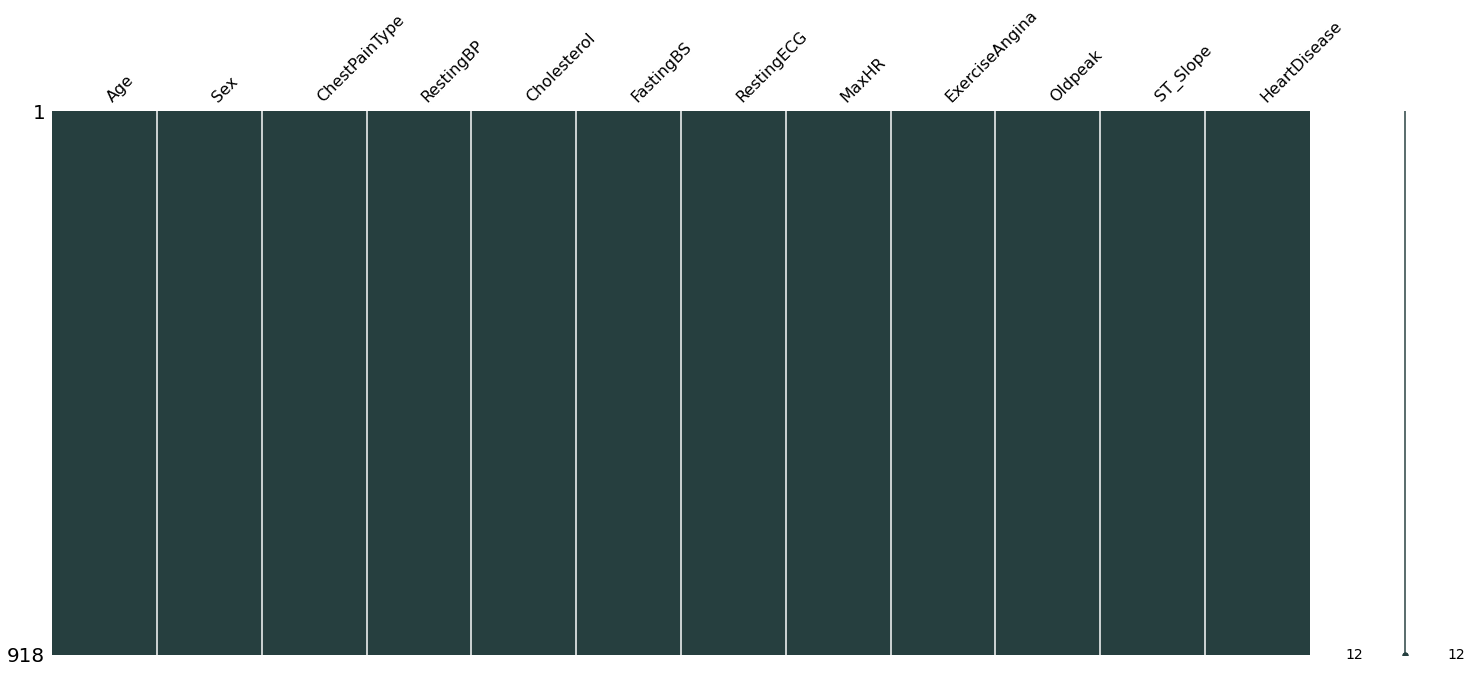

In [11]:
import missingno as msno
msno.matrix(df,color=(0.15, 0.25, 0.25))

------------------------------------
# Investigating Heart Disease to Each of Paramaters in Patients

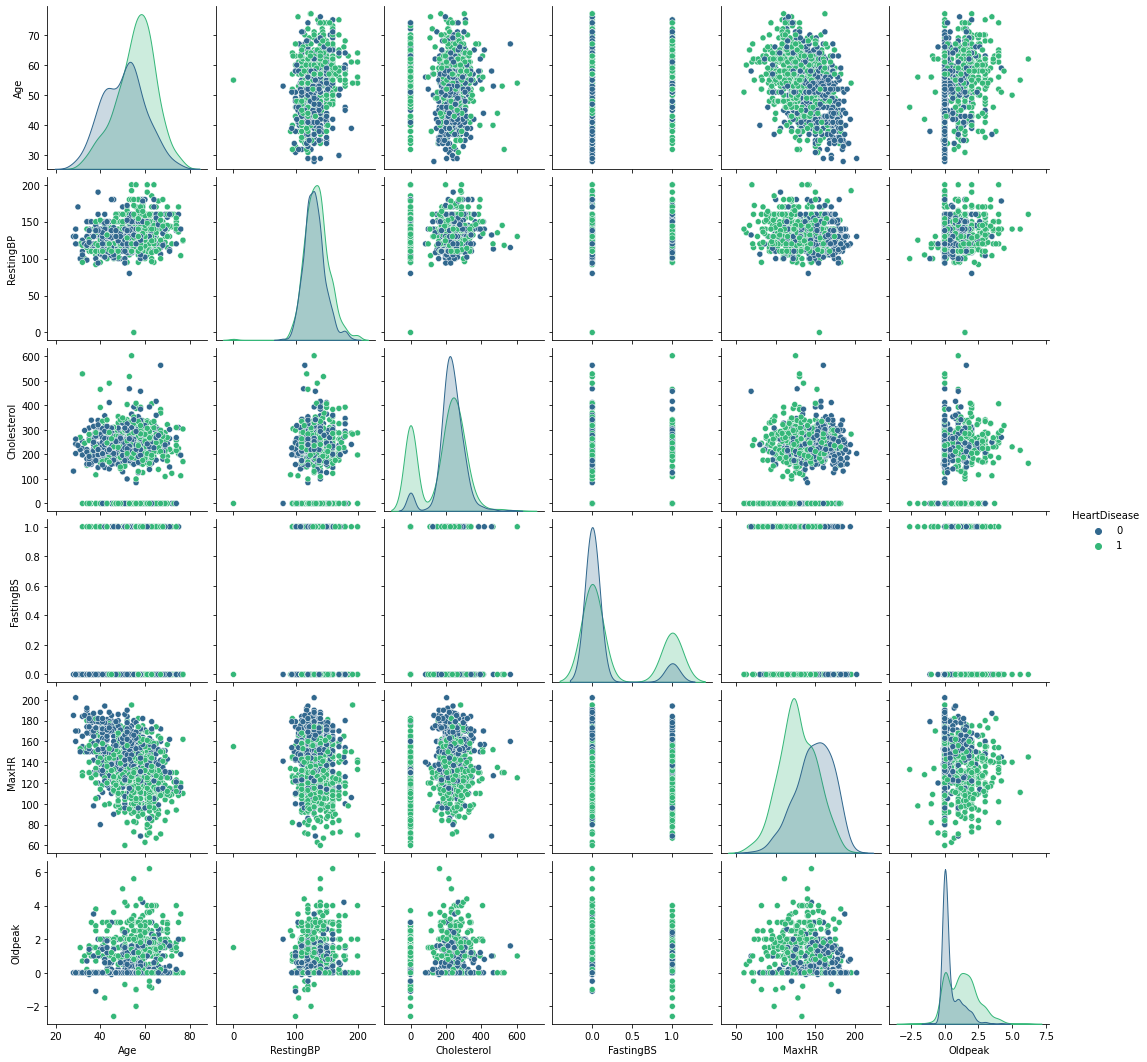

In [12]:
sns.pairplot(df,hue='HeartDisease',palette='viridis')

# What is the relationship between cholestrol levels and heart disease?

One of the main indicators of having heart diseases is the cholestrol levels in the blood. The total blood cholesterol is calculated by adding high-density lipoprotein (HDL), ligh-density lipoprotein (LDL) cholesterol levels, plus 20% of the triglyceride level.

<span style="color:Blue"> Observation:
We can observe from the following figure that healthy and diagnosed patients had similar total cholestrol levels. Thereby, we cannot draw a conclusion solely based on the cholestrol levels.
    
In the figure below, there are values that are 0. Serum cholesterol level of 0 is not possible in practice, so it can be identified as an outlier. We can then change the outlier to the median value.

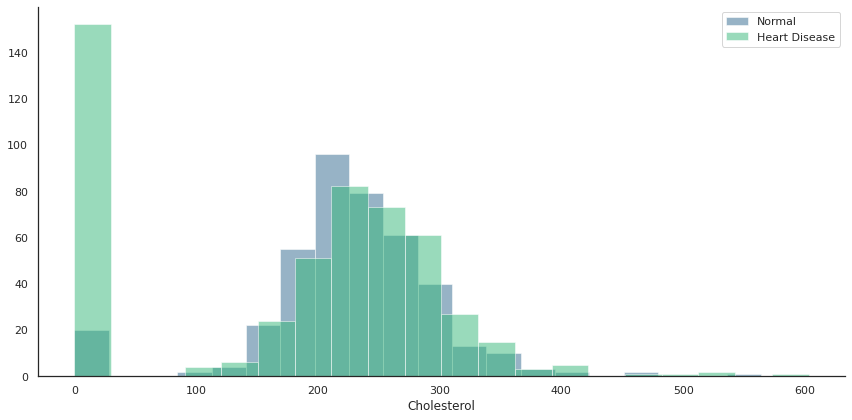

In [13]:
plot_histgram('Cholesterol')

In [14]:
df['Cholesterol'].replace(0, df['Cholesterol'].median(),inplace=True)

# What is the relationship between chest pain types and heart disease?

In this data, we investigate four different types of chest pains with heart disease:

TA: typical angina,
ATA: atypical angina,
AP: non-anginal pain,
ASY: asymptomatic.

<span style="color:Blue"> Observation:
We can observe from the following figures that most of the asymptomatic patients were in fact having heart diseases that makes the disease a silent killer.

In [15]:
df['ChestPainType'].value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

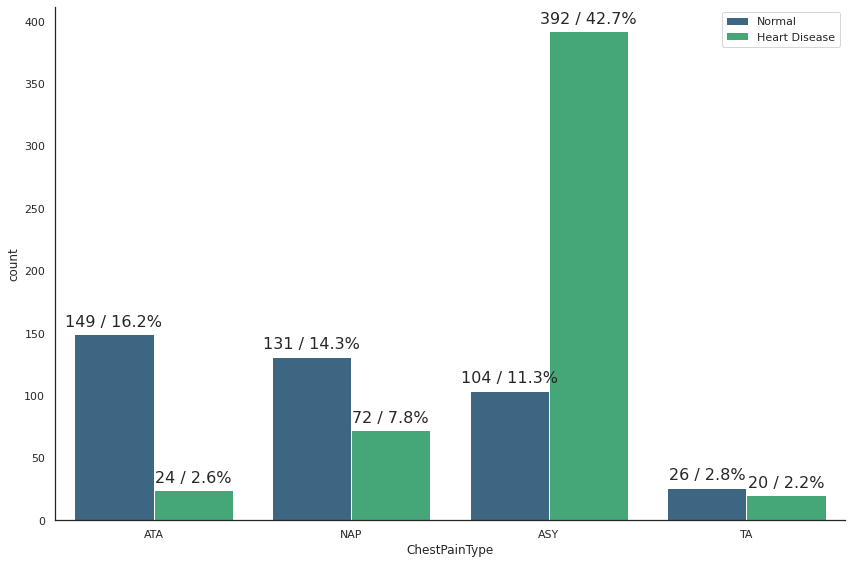

In [16]:
plot_countplot('ChestPainType')

# What is the relationship between age and gender with heart disease?

In this section, we investigate if gender has a realtionship with heart disease:

<span style="color:Blue"> Observation:
From the following figures, it can be established that although heart disease can happen even in early 30s, majority of patients with heart disease are in their mid 50s to mid 60s. It can also be seen that the ratio of diagnosed to healthy patients were much higher in men compared to women.

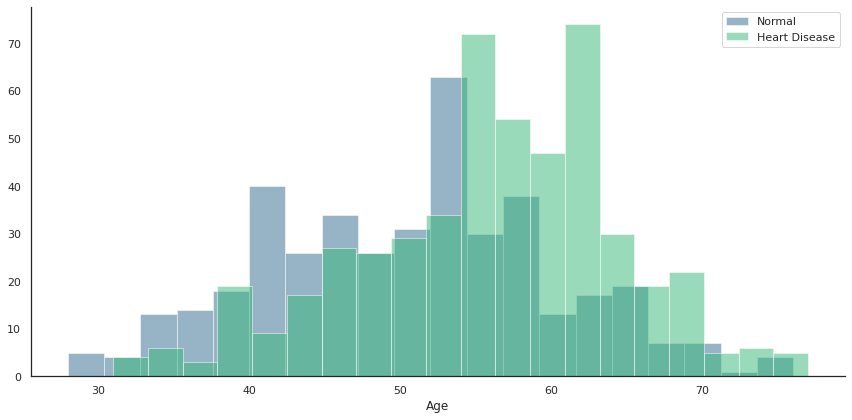

In [17]:
plot_histgram('Age')

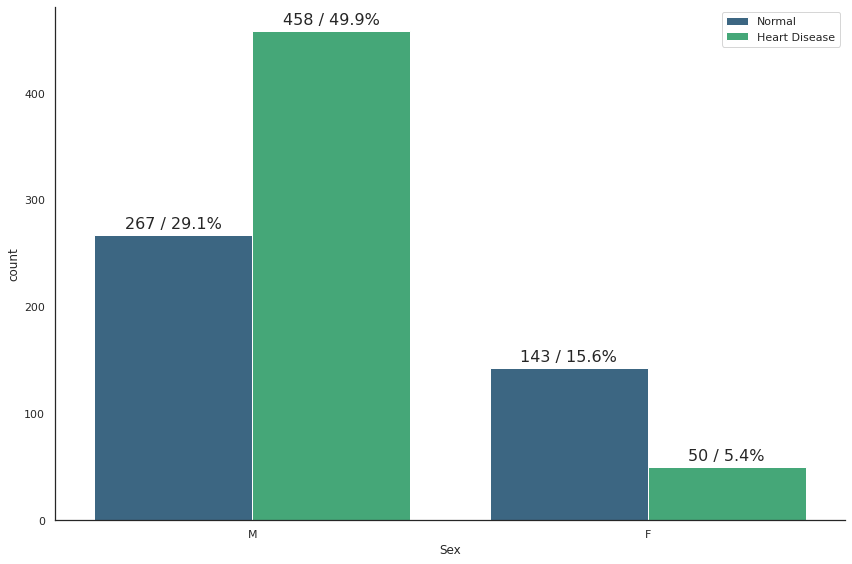

In [18]:
plot_countplot('Sex')

# Is there a relationship between resting blood pressure (BP) and electrocardiogram (ECG) data and heart disease?

In this section, we investigate if resting blood pressure (BP) and electrocardiogram (ECG) has a realtionship with heart disease:

For the resting ECG, the patinets were classified with normal, ST, and LVH. ST patients have ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV). Patients classified with LVH blood pressure showed probable or definite left ventricular hypertrophy by Estes' criteria.

<span style="color:Blue"> Observation:
From the figures, it can be established that healthy patients and patients with heart diseases had almost similar resting blood pressures that indicates resting BP cannot be an indicator of heart disease. Similarly, more than half of patinets that had a normal ECG were in fact diagnosed with heart disease. For the case of patients with ST and LVH ECG data, the majority of the patients were finally diagnosed with heart disease. Thereby, resting blood pressure and ECG cannot be solely used for the purpose of diagnosis and other indicators should be used to complement analysis.

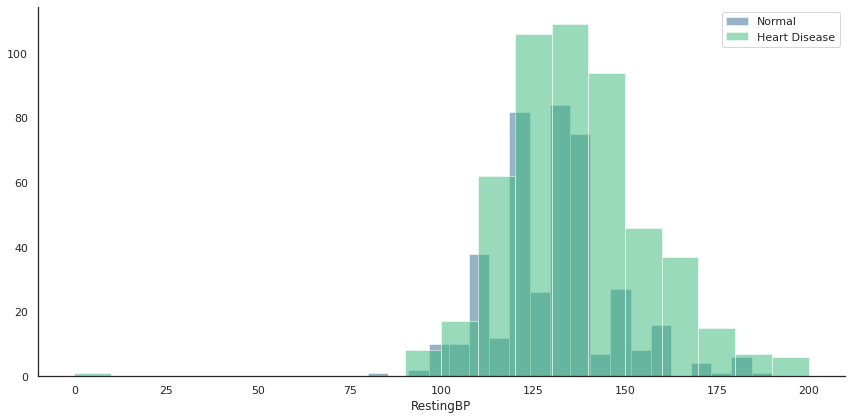

In [19]:
plot_histgram('RestingBP')
df['RestingBP'].replace(0, df['RestingBP'].median(),inplace=True)

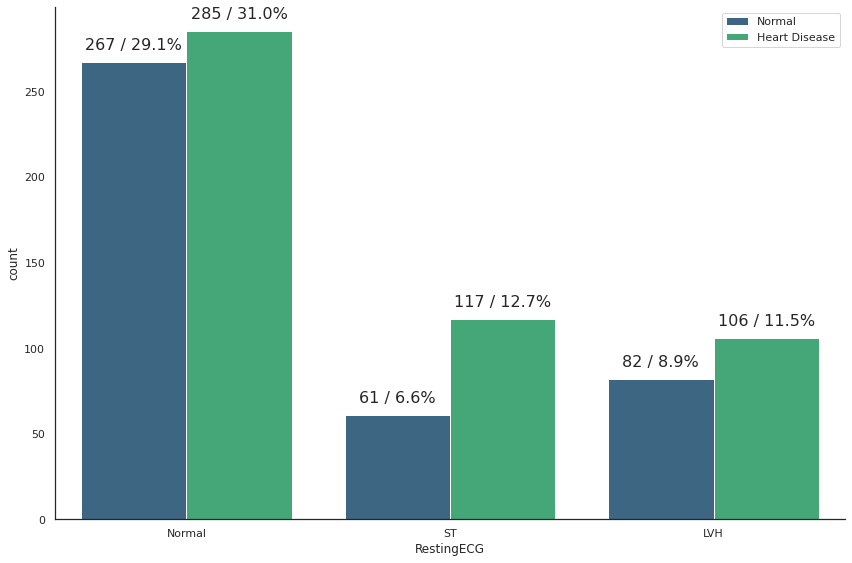

In [20]:
plot_countplot('RestingECG')

# Is there a relationship between Diabetes (fasting blood sugar (BS)) and heart disease?

In this section, we investigate if diabetes (fasting blood sugar (BS)) has a realtionship with heart disease:

Most healthy adults have a fasting blood sugar of 99 mg/dl and lower. Adults with a pre-diabetic indications usually have a blood sugar levels of 100 to 125 mg/dl. Patients diagnosed with diabetes would have fasting blood sugar levels of 125 and more. In this dataset, if the patient has a blood sugar level of 120 mg/dl and more is assumed to be diabetic (1) and values below that would be considered healthy (0).
<span style="color:Blue"> Observation:
From the figures, it can be established that most diabetic patients were diagnosed with heart disease that amplifies the importnace of regular checkups of diabetic patinets for heart diseases.

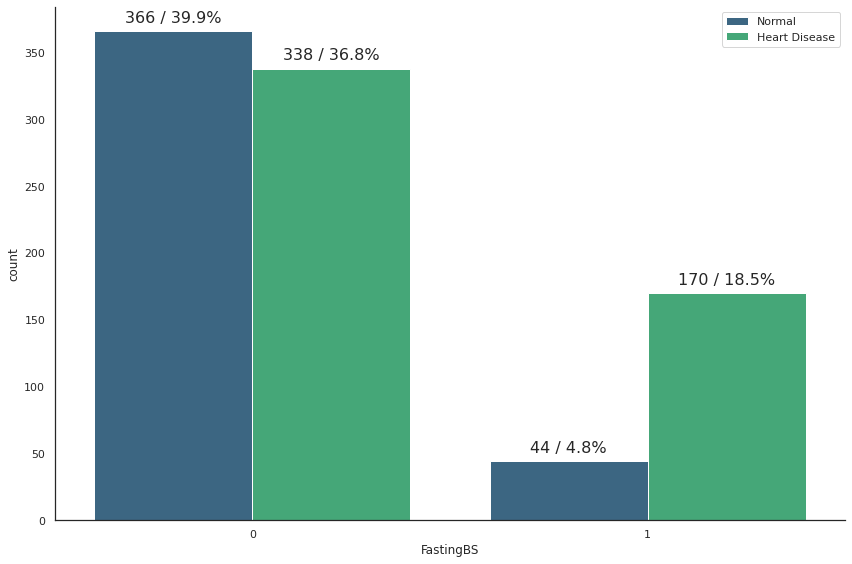

In [21]:
plot_countplot('FastingBS')

# Is there a relationship between exercise test data and the maximum heart rate achieved and heart disease?

In this section, we investigate if the data collected for exercise and heart rate has a realtionship with heart disease:

One of the most important tests to diagnose heart diseases are exerciese tests that would be a strong indicator of heart disease. Exercise-induced angina in this dataset are shown as below:
Y: Yes
N: No

Another important data is the maximum heart rate achieved by the patient that we will review below. 

<span style="color:Blue"> Observation:
From the figures, it can be established that most patients with a exercise-induced angina had a heart disease that was also exected to show a high relationship with heart disease. It can also be infered that patients with heart disease could achieve lower maximum heart rate compared to the healthy patients.

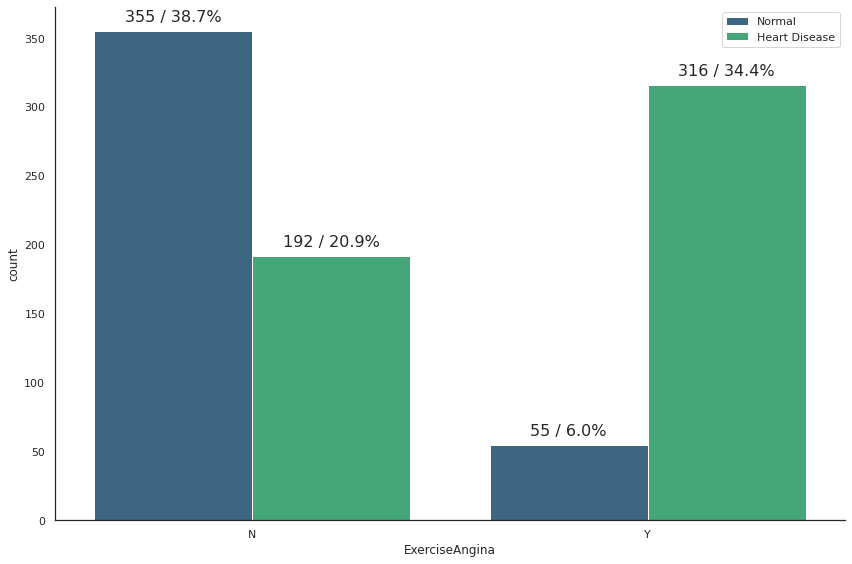

In [22]:
plot_countplot('ExerciseAngina')

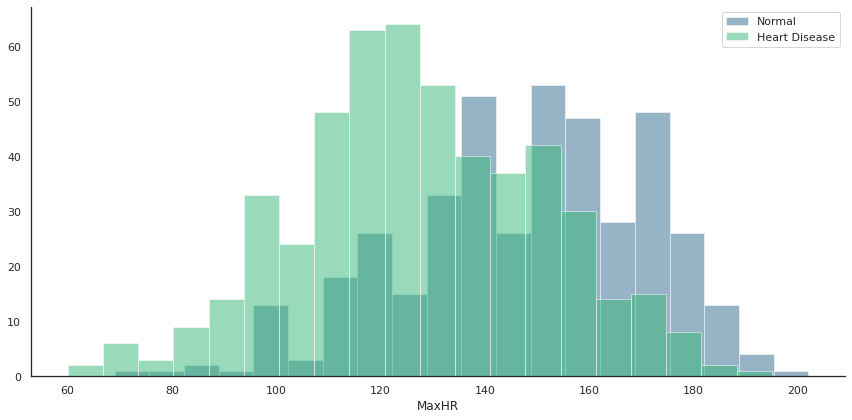

In [31]:
plot_histgram('MaxHR')

# Is there a relationship between the ST slope and heart disease?

The ST segment shift relative to exercise-induced increments in heart rate, the ST/heart rate slope (ST/HR slope), has been proposed as a more accurate ECG criterion for diagnosing significant coronary artery disease (CAD).

The slope of the peak exercise ST segment in this data set could be upsloping (Up), flat (Flat), and downsloping (Down).

<span style="color:Blue"> Observation:
From the following figure, it can be established that having a flat ST Slope is a strong indicator of having a heart disease among patients.

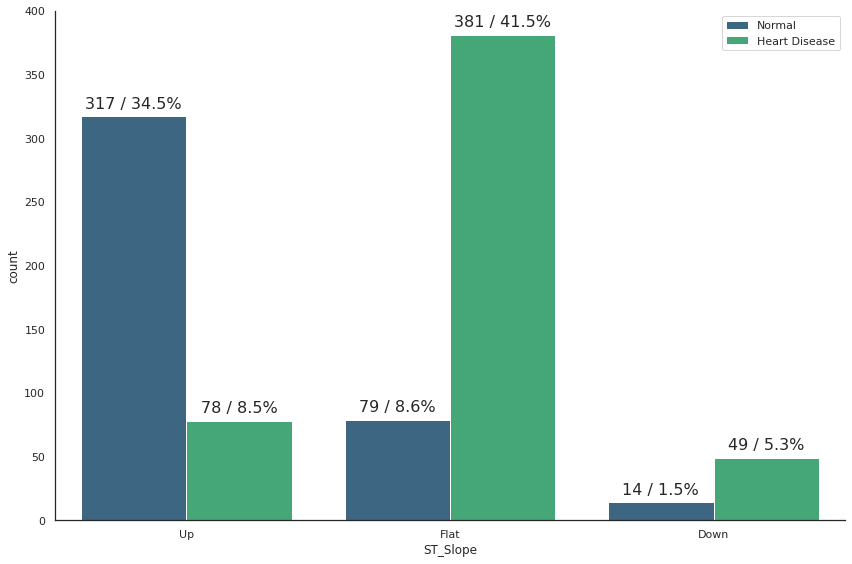

In [23]:
plot_countplot('ST_Slope')

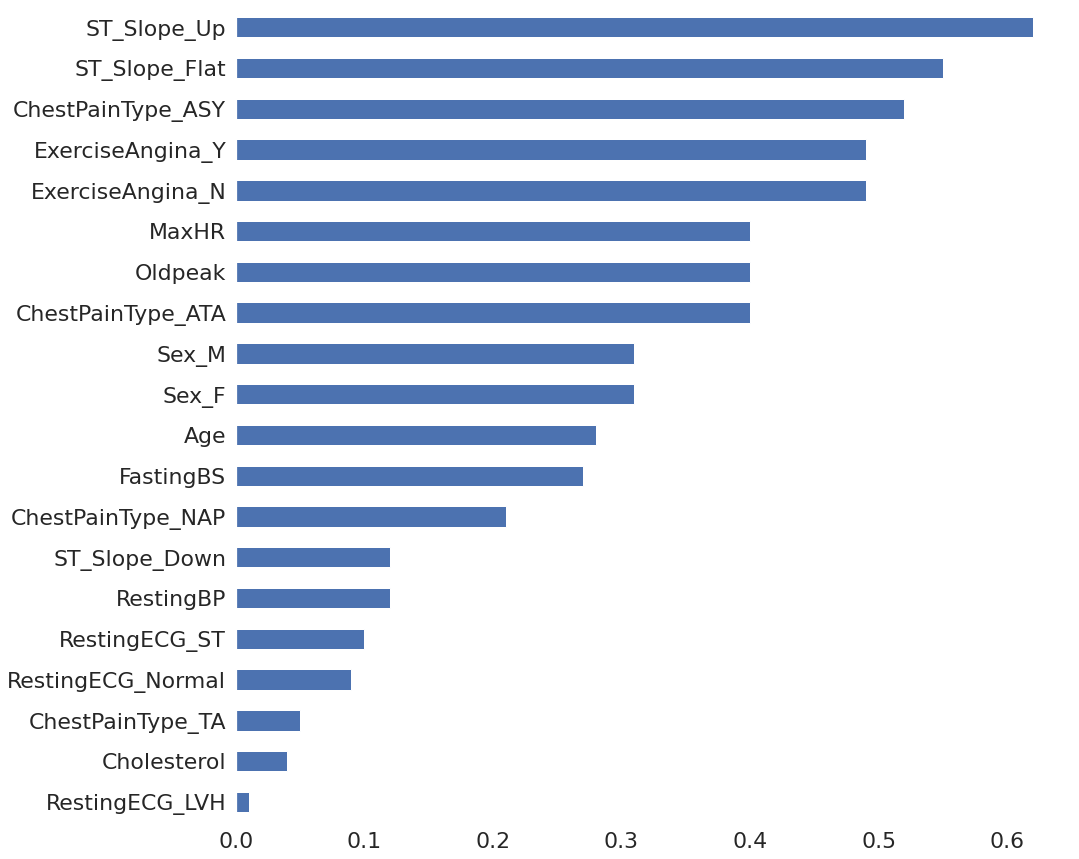

In [50]:
# Checking feature importance
corr=heart_df.corr().round(2)
sns.set(font_scale=2)
plt.figure(figsize=(15, 15))
#sns.set_style(palette='viridis')
sns.color_palette('viridis')
#sns.set_palette("bright")
abs(corr['HeartDisease']).sort_values()[:-1].plot.barh()
plt.gca().set_facecolor('#FFFFFF')
sns.despine()

------------------------------------
# Defining dummy variables

In [24]:
# Defining dummy variables for the categorical values.
df_dummies = pd.get_dummies(df,drop_first=True)
df_dummies.head(5)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


In [25]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    int64  
 1   RestingBP          918 non-null    int64  
 2   Cholesterol        918 non-null    int64  
 3   FastingBS          918 non-null    int64  
 4   MaxHR              918 non-null    int64  
 5   Oldpeak            918 non-null    float64
 6   HeartDisease       918 non-null    int64  
 7   Sex_M              918 non-null    uint8  
 8   ChestPainType_ATA  918 non-null    uint8  
 9   ChestPainType_NAP  918 non-null    uint8  
 10  ChestPainType_TA   918 non-null    uint8  
 11  RestingECG_Normal  918 non-null    uint8  
 12  RestingECG_ST      918 non-null    uint8  
 13  ExerciseAngina_Y   918 non-null    uint8  
 14  ST_Slope_Flat      918 non-null    uint8  
 15  ST_Slope_Up        918 non-null    uint8  
dtypes: float64(1), int64(6), u

# Modeling - Preparing the model for Logistic Regression.

In [26]:
heart_df = df_dummies.copy()
heart_df

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,1,0,0,1,1,0,0,1,0
914,68,144,193,1,141,3.4,1,1,0,0,0,1,0,0,1,0
915,57,130,131,0,115,1.2,1,1,0,0,0,1,0,1,1,0
916,57,130,236,0,174,0.0,1,0,1,0,0,0,0,0,1,0


In [27]:
X = heart_df.drop('HeartDisease',axis=1)
y = heart_df.pop('HeartDisease')

In [28]:
all_cols = [cname for cname in X.columns]
print(all_cols)
target="HeartDisease"

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']


In [29]:
string_col = df.select_dtypes(include="object").columns
df[string_col]=df[string_col].astype("string")
string_col
heart_df=pd.get_dummies(df,columns=string_col,drop_first=False)
heart_df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


In [52]:
#X=df_scaled
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=300)
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
acc_log=[]

kf=model_selection.StratifiedKFold(n_splits=5)
for fold , (trn_,tst_) in enumerate(kf.split(X=X,y=y)):
    
    X_train=heart_df.loc[trn_,all_cols]
    y_train=heart_df.loc[trn_,target]
    
    X_test=heart_df.loc[tst_,all_cols]
    y_test=heart_df.loc[tst_,target]
    
    #print(pd.DataFrame(X_test).head())
    ro_scaler=StandardScaler()
    X_train=ro_scaler.fit_transform(X_train)
    X_test=ro_scaler.transform(X_test)
    
    
    clf=LogisticRegression()
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print(f"The fold is : {fold} : ")
    print(classification_report(y_test,y_pred))
    acc=roc_auc_score(y_test,y_pred)
    acc_log.append(acc)
    print(f"The accuracy for Fold {fold+1} : {acc}")
    print(confusion_matrix(y_test,y_pred))
    pass

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        82
           1       0.94      0.85      0.89       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184

The accuracy for Fold 1 : 0.8898852223816357
[[76  6]
 [15 87]]
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        82
           1       0.91      0.81      0.86       102

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184

The accuracy for Fold 2 : 0.8580822572931611
[[74  8]
 [19 83]]
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.96      0.66      0.78        82
           1       0.78      0.98      0.87       10

<span style="color:Blue"> Observation:
We can observe different fold values would result in different evaluation parameters. In this model, to have the lowest false negatives that could put patients' lives in danger, the author suggests using the fold value of 2.
    